# Preparing Image Data For Modeling

This notebook will turn the images into their respective matrix and save the csv so our modeling notebooks can train on them

In [15]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
from torchvision.ops import box_iou
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [18]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

csv_path = os.path.join(base_dir, "Data", "Train_test", "Counts_BB.csv")
image_dir = os.path.join(base_dir, "Data", "Train_test")

In [19]:
# Load dataframe
df = pd.read_csv(csv_path)
df

,Unnamed: 0,frame_name,sperm_count,cluster_count,small_or_pinhead_count,folder,fid,class,bb0,bb1,bb2,bb3
0,0,14_frame_0,3,0,0,14,ckyw6zzlj001r3867thf0fuy7,0,0.208594,0.825000,0.035937,0.037500
1,1,14_frame_0,3,0,0,14,ckyw704kw001v3867kvyjtx6k,0,0.796094,0.797917,0.029687,0.037500
2,2,14_frame_0,3,0,0,14,ckyw708pn001z386779fr849h,0,0.827344,0.123958,0.035937,0.039583
3,3,14_frame_1,3,0,0,14,ckyw6zzlj001r3867thf0fuy7,0,0.208594,0.814583,0.035937,0.037500
4,4,14_frame_1,3,0,0,14,ckyw704kw001v3867kvyjtx6k,0,0.764062,0.781250,0.029687,0.037500
...,...,...,...,...,...,...,...,...,...,...,...,...
19836,19836,52_frame_427,6,0,2,52,cl1x89ze6000o3f6baic4zklo,0,0.464062,0.462500,0.037500,0.054167
19837,19837,52_frame_427,6,0,2,52,cl1x8a7j3000s3f6bvn1rm1tw,0,0.416406,0.400000,0.029687,0.045833
19838,19838,52_frame_427,6,0,2,52,cl1x8ih7n00103f6b67egfbw2,0,0.057031,0.803125,0.032813,0.043750
19839,19839,52_frame_427,6,0,2,52,cl52g254u000o3b6gcyhoi1fk,2,0.132031,0.112500,0.026562,0.037500


In [20]:


# Function to load, resize, vectorize, and normalize images
def vectorize_and_normalize_image(image_name, target_size=(128, 128)):
    # Load the image from the directory
    image_path = os.path.join(image_dir, f"{image_name}.jpg")

    # Read the image using OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image was successfully loaded
    if img is not None:
        # Resize the image to a target size (reduce memory consumption)
        img_resized = cv2.resize(img, target_size)

        # Normalize the image (scaling pixel values to range 0-1)
        img_normalized = img_resized / 255.0

        return img_normalized
    else:
        print(f"Warning: Unable to load image {image_name}.jpg")
        return None

# Create a new column 'images' with normalized and resized image data (no flattening)
df['images'] = df['frame_name'].apply(lambda x: vectorize_and_normalize_image(x))

# Check the updated DataFrame
df.head()


,Unnamed: 0,frame_name,sperm_count,cluster_count,small_or_pinhead_count,folder,fid,class,bb0,bb1,bb2,bb3,images
0,0,14_frame_0,3,0,0,14,ckyw6zzlj001r3867thf0fuy7,0,0.208594,0.825000,0.035937,0.037500,"[[0.3843137254901961, 0.37254901960784315, 0.3..."
1,1,14_frame_0,3,0,0,14,ckyw704kw001v3867kvyjtx6k,0,0.796094,0.797917,0.029687,0.037500,"[[0.3843137254901961, 0.37254901960784315, 0.3..."
2,2,14_frame_0,3,0,0,14,ckyw708pn001z386779fr849h,0,0.827344,0.123958,0.035937,0.039583,"[[0.3843137254901961, 0.37254901960784315, 0.3..."
3,3,14_frame_1,3,0,0,14,ckyw6zzlj001r3867thf0fuy7,0,0.208594,0.814583,0.035937,0.037500,"[[0.3843137254901961, 0.37254901960784315, 0.3..."
4,4,14_frame_1,3,0,0,14,ckyw704kw001v3867kvyjtx6k,0,0.764062,0.781250,0.029687,0.037500,"[[0.3843137254901961, 0.37254901960784315, 0.3..."


In [21]:
df['images'][0].shape

(128, 128)

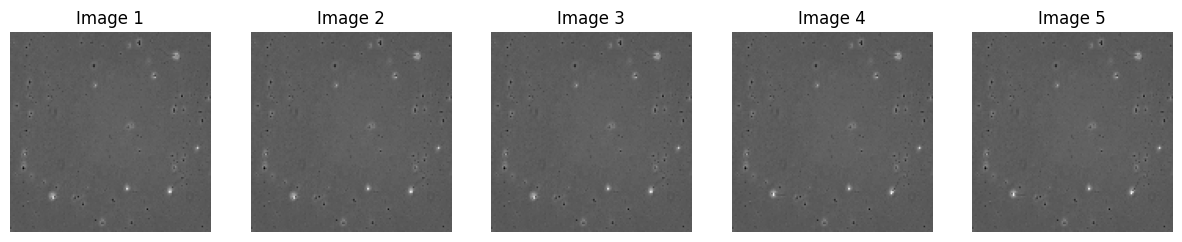

In [22]:
import matplotlib.pyplot as plt

# Function to plot images from the DataFrame
def plot_images_from_df(df, num_images=5):
    """
    Plot a set of images from the DataFrame
    Args:
    - df: DataFrame containing the image data
    - num_images: number of images to display (default is 5)
    """
    # Ensure we don't exceed the number of available images
    num_images = min(num_images, len(df))

    # Set up the plot grid (e.g., for 5 images, a 1x5 grid)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    # Loop through and plot the images
    for i, (index, row) in enumerate(df.head(num_images).iterrows()):
        # Get the image from the 'images' column
        image = row['images']

        # Plot the image
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")

    plt.show()

# Example usage
plot_images_from_df(df, num_images=5)

In [23]:
# Original dimensions
original_width = 640
original_height = 480

# New dimensions
new_width = 128
new_height = 128

# Scaling factors
width_scale = new_width / original_width
height_scale = new_height / original_height

# Function to resize YOLO bounding boxes
def resize_bb(row):
    # Scale the bounding box components: [x_center, y_center, width, height]
    x_center_new = row['bb0'] * width_scale
    y_center_new = row['bb1'] * height_scale
    width_new = row['bb2'] * width_scale
    height_new = row['bb3'] * height_scale
    return pd.Series([x_center_new, y_center_new, width_new, height_new])

# Apply the function and create new columns for resized bounding boxes
df[['resized_bb0', 'resized_bb1', 'resized_bb2', 'resized_bb3']] = df.apply(resize_bb, axis=1)

# Display the updated dataframe
df


,Unnamed: 0,frame_name,sperm_count,cluster_count,small_or_pinhead_count,folder,fid,class,bb0,bb1,bb2,bb3,images,resized_bb0,resized_bb1,resized_bb2,resized_bb3
0,0,14_frame_0,3,0,0,14,ckyw6zzlj001r3867thf0fuy7,0,0.208594,0.825000,0.035937,0.037500,"[[0.3843137254901961, 0.37254901960784315, 0.3...",0.041719,0.220000,0.007187,0.010000
1,1,14_frame_0,3,0,0,14,ckyw704kw001v3867kvyjtx6k,0,0.796094,0.797917,0.029687,0.037500,"[[0.3843137254901961, 0.37254901960784315, 0.3...",0.159219,0.212778,0.005938,0.010000
2,2,14_frame_0,3,0,0,14,ckyw708pn001z386779fr849h,0,0.827344,0.123958,0.035937,0.039583,"[[0.3843137254901961, 0.37254901960784315, 0.3...",0.165469,0.033056,0.007187,0.010556
3,3,14_frame_1,3,0,0,14,ckyw6zzlj001r3867thf0fuy7,0,0.208594,0.814583,0.035937,0.037500,"[[0.3843137254901961, 0.37254901960784315, 0.3...",0.041719,0.217222,0.007187,0.010000
4,4,14_frame_1,3,0,0,14,ckyw704kw001v3867kvyjtx6k,0,0.764062,0.781250,0.029687,0.037500,"[[0.3843137254901961, 0.37254901960784315, 0.3...",0.152813,0.208333,0.005938,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19836,19836,52_frame_427,6,0,2,52,cl1x89ze6000o3f6baic4zklo,0,0.464062,0.462500,0.037500,0.054167,"[[0.47058823529411764, 0.4588235294117647, 0.4...",0.092813,0.123333,0.007500,0.014444
19837,19837,52_frame_427,6,0,2,52,cl1x8a7j3000s3f6bvn1rm1tw,0,0.416406,0.400000,0.029687,0.045833,"[[0.47058823529411764, 0.4588235294117647, 0.4...",0.083281,0.106667,0.005938,0.012222
19838,19838,52_frame_427,6,0,2,52,cl1x8ih7n00103f6b67egfbw2,0,0.057031,0.803125,0.032813,0.043750,"[[0.47058823529411764, 0.4588235294117647, 0.4...",0.011406,0.214167,0.006563,0.011667
19839,19839,52_frame_427,6,0,2,52,cl52g254u000o3b6gcyhoi1fk,2,0.132031,0.112500,0.026562,0.037500,"[[0.47058823529411764, 0.4588235294117647, 0.4...",0.026406,0.030000,0.005313,0.010000


In [ ]:
df.to_csv('Data Final/image_bb_counts_data.csv')


In [ ]:
data = pd.read_csv('Data Final/image_bb_counts_data.csv')
data

,Unnamed: 0.1,Unnamed: 0,frame_name,sperm_count,cluster_count,small_or_pinhead_count,folder,fid,class,bb0,bb1,bb2,bb3,images,resized_bb0,resized_bb1,resized_bb2,resized_bb3
0,0,0,14_frame_0,3,0,0,14,ckyw6zzlj001r3867thf0fuy7,0,0.208594,0.825000,0.035937,0.037500,[[0.38431373 0.37254902 0.37647059 ... 0.37254...,0.041719,0.220000,0.007187,0.010000
1,1,1,14_frame_0,3,0,0,14,ckyw704kw001v3867kvyjtx6k,0,0.796094,0.797917,0.029687,0.037500,[[0.38431373 0.37254902 0.37647059 ... 0.37254...,0.159219,0.212778,0.005938,0.010000
2,2,2,14_frame_0,3,0,0,14,ckyw708pn001z386779fr849h,0,0.827344,0.123958,0.035937,0.039583,[[0.38431373 0.37254902 0.37647059 ... 0.37254...,0.165469,0.033056,0.007187,0.010556
3,3,3,14_frame_1,3,0,0,14,ckyw6zzlj001r3867thf0fuy7,0,0.208594,0.814583,0.035937,0.037500,[[0.38431373 0.37254902 0.37647059 ... 0.37254...,0.041719,0.217222,0.007187,0.010000
4,4,4,14_frame_1,3,0,0,14,ckyw704kw001v3867kvyjtx6k,0,0.764062,0.781250,0.029687,0.037500,[[0.38431373 0.37254902 0.37647059 ... 0.37254...,0.152812,0.208333,0.005938,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19836,19836,19836,52_frame_427,6,0,2,52,cl1x89ze6000o3f6baic4zklo,0,0.464062,0.462500,0.037500,0.054167,[[0.47058824 0.45882353 0.4627451 ... 0.43921...,0.092813,0.123333,0.007500,0.014444
19837,19837,19837,52_frame_427,6,0,2,52,cl1x8a7j3000s3f6bvn1rm1tw,0,0.416406,0.400000,0.029687,0.045833,[[0.47058824 0.45882353 0.4627451 ... 0.43921...,0.083281,0.106667,0.005938,0.012222
19838,19838,19838,52_frame_427,6,0,2,52,cl1x8ih7n00103f6b67egfbw2,0,0.057031,0.803125,0.032813,0.043750,[[0.47058824 0.45882353 0.4627451 ... 0.43921...,0.011406,0.214167,0.006562,0.011667
19839,19839,19839,52_frame_427,6,0,2,52,cl52g254u000o3b6gcyhoi1fk,2,0.132031,0.112500,0.026562,0.037500,[[0.47058824 0.45882353 0.4627451 ... 0.43921...,0.026406,0.030000,0.005313,0.010000


## Baseline model

1. Lost Function used:  The model uses the Mean Squared Error loss function for training and evaluation.

2. Model Architecture:

Convolutional Neural Network (CNN) with the following structure:

Conv2D Layer: 16 filters, kernel size (3, 3), activation 'relu', input shape (128, 128, 1)

MaxPooling2D Layer: pool size (2, 2)

Flatten Layer

Dense Layer: 32 neurons, activation 'relu'

Dense Output Layer: 4 neurons (likely corresponding to bounding box coordinates)

3. Hyperparameters:
Optimizer: Adam optimizer with a learning rate of 0.001

Epochs: 10

Batch Size: 32

Input Image Size: (128, 128)

In [ ]:
# Features (X) and Target (y)
X = np.stack(df['images'].values)
y = df[['resized_bb0', 'resized_bb1', 'resized_bb2', 'resized_bb3']].values  # Use resized BBoxes!

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Simplest possible CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(4)  # Predict 4 bounding box values
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()




d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 63504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │     2,032,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,032,452 (7.75 MB)

 Trainable params: 2,032,452 (7.75 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Helper: Convert YOLO to corners for IoU calculation
def yolo_to_corners_batch(yolo_boxes, img_width=128, img_height=128):
    yolo_boxes = yolo_boxes.copy()
    yolo_boxes[:, 0] *= img_width
    yolo_boxes[:, 1] *= img_height
    yolo_boxes[:, 2] *= img_width
    yolo_boxes[:, 3] *= img_height

    xmin = yolo_boxes[:, 0] - yolo_boxes[:, 2] / 2
    ymin = yolo_boxes[:, 1] - yolo_boxes[:, 3] / 2
    xmax = yolo_boxes[:, 0] + yolo_boxes[:, 2] / 2
    ymax = yolo_boxes[:, 1] + yolo_boxes[:, 3] / 2

    return np.stack([xmin, ymin, xmax, ymax], axis=1)

# Helper: Calculate IoU metric
def validate_iou_keras(model, X_test, y_test):
    preds = model.predict(X_test)
    
    pred_corners = yolo_to_corners_batch(preds)
    true_corners = yolo_to_corners_batch(y_test)

    pred_boxes = torch.tensor(pred_corners, dtype=torch.float32)
    true_boxes = torch.tensor(true_corners, dtype=torch.float32)

    ious = box_iou(pred_boxes, true_boxes)
    matched_ious = ious.diagonal().numpy()

    mean_iou = matched_ious.mean()
    print(f"📏 Validation: Mean IoU = {mean_iou:.4f}")
    return mean_iou

4. Performance Matrics: MSE, MAE and RMSE

In [26]:
# Training
epochs = 10
iou_scores = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    print(f"\n📚 Epoch {epoch+1}/{epochs}")
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=1,
        batch_size=32,
        verbose=1
    )
    
    train_losses.append(history.history['loss'][0])
    val_losses.append(history.history['val_loss'][0])

    mean_iou = validate_iou_keras(model, X_test, y_test)
    iou_scores.append(mean_iou)


📚 Epoch 1/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0808 - val_loss: 0.0020
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
📏 Validation: Mean IoU = 0.0061

📚 Epoch 2/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0019 - val_loss: 0.0019
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
📏 Validation: Mean IoU = 0.0009

📚 Epoch 3/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0019 - val_loss: 0.0019
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
📏 Validation: Mean IoU = 0.0011

📚 Epoch 4/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0019 - val_loss: 0.0019
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
📏 Validation: Mean IoU = 0.0009

📚 Epoch 5/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0019 - val_loss: 0.0019
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
📏 Validation: Mean IoU = 0.0004

📚 Epoch 6/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0019 - val_loss: 0.0019
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
📏 Validation: Mean IoU = 0.0014

📚 Epoch 7/10
496/496

In [27]:
# Calculate overall metrics
test_preds = model.predict(X_test)
mse = np.mean((test_preds - y_test)**2)
mae = np.mean(np.abs(test_preds - y_test))
print(f"\nOverall Test Metrics:")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {np.sqrt(mse):.6f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Overall Test Metrics:
MSE: 0.001909
MAE: 0.027694
RMSE: 0.043693


In [ ]:
# Add predictions to DataFrame
df['pred_bb0'], df['pred_bb1'], df['pred_bb2'], df['pred_bb3'] = model.predict(X).T

621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019

📉 Final Test Loss (MSE): 0.001909


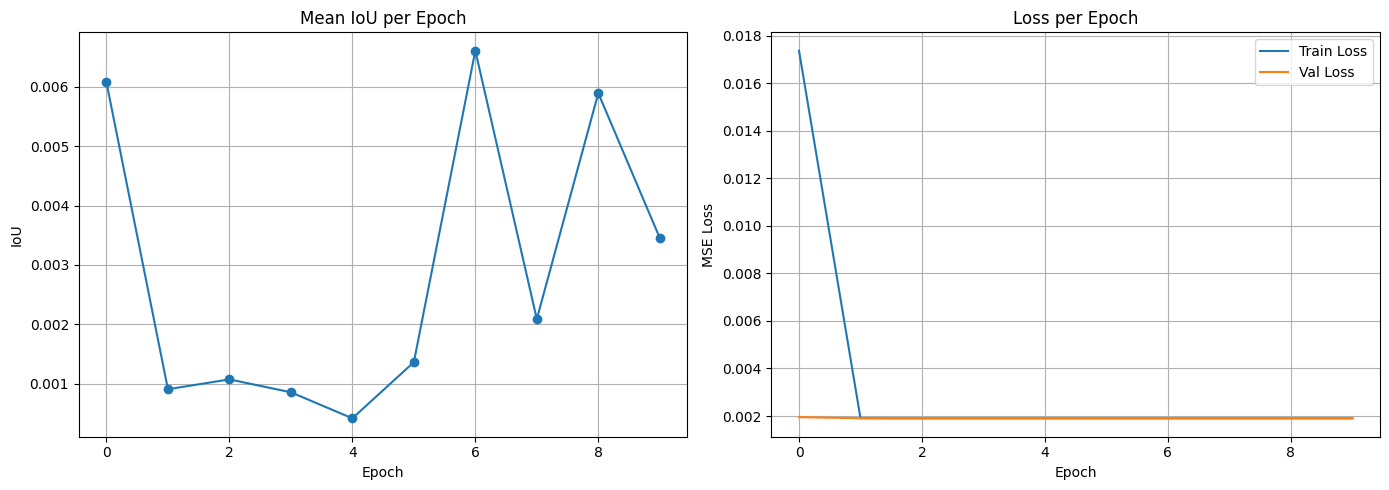

In [28]:
# Final evaluation
test_loss = model.evaluate(X_test, y_test)
print(f"\n📉 Final Test Loss (MSE): {test_loss:.6f}")

# Plots
plt.figure(figsize=(14, 5))

# IoU Plot
plt.subplot(1, 2, 1)
plt.plot(iou_scores, marker='o')
plt.title("Mean IoU per Epoch")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
